<a href="https://colab.research.google.com/github/oliverturpo/MML-CLIVER/blob/main/Trabajo_Final_Bayesiana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.5 MB/s eta 0:00:00


EJERCICIO 1: OPTIMIZACIÓN BAYESIANA DE HIPERPARÁMETROS

[1/4] Cargando dataset Breast Cancer...
      Dimensiones: (569, 30), Clases: [0 1]

[2/4] Ejecutando Optimización Bayesiana...

[3/4] Ejecutando Grid Search...

[4/4] Generando visualizaciones...
      ✓ Gráfico guardado: ejercicio1_optimizacion_bayesiana.png


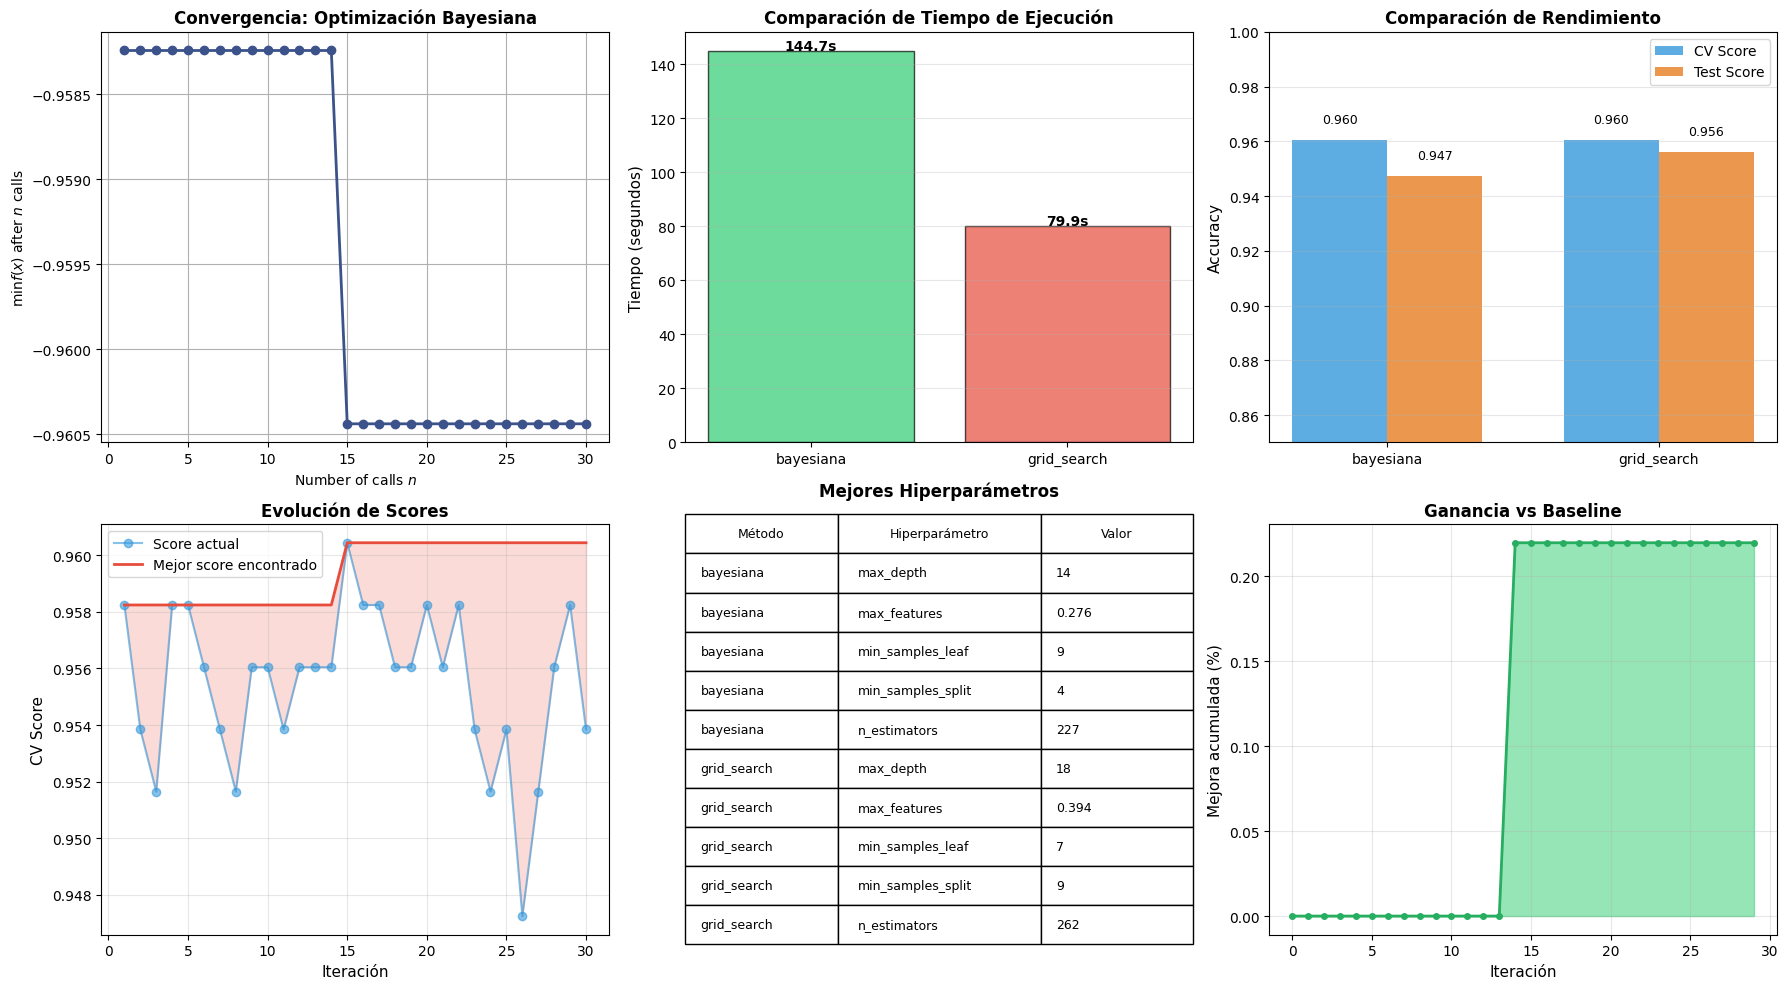


REPORTE: OPTIMIZACIÓN BAYESIANA vs GRID SEARCH

BAYESIANA:
  • Mejor CV Score: 0.9604
  • Test Accuracy: 0.9474
  • Tiempo: 144.70s

GRID SEARCH:
  • Mejor CV Score: 0.9604
  • Test Accuracy: 0.9561
  • Tiempo: 79.92s

COMPARACIÓN:
  • Bayesiana es 81.1% más lenta
  • Mejora accuracy: -0.88 pp



In [3]:
"""
EJERCICIO 1: OPTIMIZACIÓN BAYESIANA DE HIPERPARÁMETROS
Versión para Google Colab
Autor: Cliver

INSTALACIÓN PREVIA (ejecutar en celda separada):
!pip install scikit-optimize
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.plots import plot_convergence, plot_objective
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import time
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CLASE PRINCIPAL
# ============================================================================

class OptimizadorBayesiano:
    """
    Optimización bayesiana de hiperparámetros con comparación vs Grid Search
    Usa enfoque matricial para eficiencia
    """

    def __init__(self, X, y, test_size=0.2, random_state=42):
        """Inicializa y prepara datos"""
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        # Normalización matricial
        self.scaler = StandardScaler()
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)

        self.resultados = {}

    def optimizacion_bayesiana(self, n_iter=30):
        """Optimización bayesiana con scikit-optimize"""
        espacio_busqueda = {
            'n_estimators': Integer(50, 300),
            'max_depth': Integer(3, 20),
            'min_samples_split': Integer(2, 20),
            'min_samples_leaf': Integer(1, 10),
            'max_features': Real(0.1, 1.0)
        }

        opt = BayesSearchCV(
            RandomForestClassifier(random_state=42),
            espacio_busqueda,
            n_iter=n_iter,
            cv=5,
            n_jobs=-1,
            random_state=42,
            scoring='accuracy',
            verbose=0
        )

        inicio = time.time()
        opt.fit(self.X_train, self.y_train)
        tiempo_bayes = time.time() - inicio

        y_pred = opt.predict(self.X_test)
        accuracy_bayes = accuracy_score(self.y_test, y_pred)

        self.resultados['bayesiana'] = {
            'optimizador': opt,
            'mejor_params': opt.best_params_,
            'mejor_score_cv': opt.best_score_,
            'accuracy_test': accuracy_bayes,
            'tiempo': tiempo_bayes,
            'cv_results': opt.cv_results_
        }

        return opt

    def grid_search_baseline(self, n_configs=30):
        """Randomized Search como baseline"""
        param_dist = {
            'n_estimators': randint(50, 300),
            'max_depth': randint(3, 20),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'max_features': uniform(0.1, 0.9)
        }

        grid = RandomizedSearchCV(
            RandomForestClassifier(random_state=42),
            param_dist,
            n_iter=n_configs,
            cv=5,
            n_jobs=-1,
            random_state=42,
            scoring='accuracy',
            verbose=0
        )

        inicio = time.time()
        grid.fit(self.X_train, self.y_train)
        tiempo_grid = time.time() - inicio

        y_pred = grid.predict(self.X_test)
        accuracy_grid = accuracy_score(self.y_test, y_pred)

        self.resultados['grid_search'] = {
            'optimizador': grid,
            'mejor_params': grid.best_params_,
            'mejor_score_cv': grid.best_score_,
            'accuracy_test': accuracy_grid,
            'tiempo': tiempo_grid,
            'cv_results': grid.cv_results_
        }

        return grid

    def visualizar_comparacion(self):
        """Visualización completa de resultados"""
        fig = plt.figure(figsize=(18, 10))

        # 1. Convergencia Bayesiana
        ax1 = plt.subplot(2, 3, 1)
        if 'bayesiana' in self.resultados:
            plot_convergence(self.resultados['bayesiana']['optimizador'].optimizer_results_[0], ax=ax1)
            ax1.set_title('Convergencia: Optimización Bayesiana', fontsize=12, fontweight='bold')

        # 2. Comparación de tiempos
        ax2 = plt.subplot(2, 3, 2)
        metodos = list(self.resultados.keys())
        tiempos = [self.resultados[m]['tiempo'] for m in metodos]
        colores = ['#2ecc71', '#e74c3c']
        bars = ax2.bar(metodos, tiempos, color=colores, alpha=0.7, edgecolor='black')
        ax2.set_ylabel('Tiempo (segundos)', fontsize=11)
        ax2.set_title('Comparación de Tiempo de Ejecución', fontsize=12, fontweight='bold')

        for bar, t in zip(bars, tiempos):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{t:.1f}s', ha='center', fontsize=10, fontweight='bold')
        ax2.grid(axis='y', alpha=0.3)

        # 3. Comparación de accuracy
        ax3 = plt.subplot(2, 3, 3)
        acc_cv = [self.resultados[m]['mejor_score_cv'] for m in metodos]
        acc_test = [self.resultados[m]['accuracy_test'] for m in metodos]

        x = np.arange(len(metodos))
        width = 0.35
        bars1 = ax3.bar(x - width/2, acc_cv, width, label='CV Score', color='#3498db', alpha=0.8)
        bars2 = ax3.bar(x + width/2, acc_test, width, label='Test Score', color='#e67e22', alpha=0.8)

        ax3.set_ylabel('Accuracy', fontsize=11)
        ax3.set_title('Comparación de Rendimiento', fontsize=12, fontweight='bold')
        ax3.set_xticks(x)
        ax3.set_xticklabels(metodos)
        ax3.legend()
        ax3.set_ylim(0.85, 1.0)
        ax3.grid(axis='y', alpha=0.3)

        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax3.text(bar.get_x() + bar.get_width()/2, height + 0.005,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=9)

        # 4. Evolución de scores
        ax4 = plt.subplot(2, 3, 4)
        if 'bayesiana' in self.resultados:
            cv_results = self.resultados['bayesiana']['cv_results']
            scores = cv_results['mean_test_score']
            iteraciones = np.arange(1, len(scores) + 1)
            max_acumulado = np.maximum.accumulate(scores)

            ax4.plot(iteraciones, scores, 'o-', color='#3498db', label='Score actual', alpha=0.6)
            ax4.plot(iteraciones, max_acumulado, '-', color='#e74c3c',
                    linewidth=2, label='Mejor score encontrado')
            ax4.fill_between(iteraciones, scores, max_acumulado, alpha=0.2, color='#e74c3c')
            ax4.set_xlabel('Iteración', fontsize=11)
            ax4.set_ylabel('CV Score', fontsize=11)
            ax4.set_title('Evolución de Scores', fontsize=12, fontweight='bold')
            ax4.legend()
            ax4.grid(alpha=0.3)

        # 5. Tabla de hiperparámetros
        ax5 = plt.subplot(2, 3, 5)
        ax5.axis('off')

        tabla_data = []
        for metodo in metodos:
            params = self.resultados[metodo]['mejor_params']
            for key, val in params.items():
                tabla_data.append([metodo, key, f'{val:.3f}' if isinstance(val, float) else str(val)])

        tabla = ax5.table(cellText=tabla_data, colLabels=['Método', 'Hiperparámetro', 'Valor'],
                         cellLoc='left', loc='center', colWidths=[0.3, 0.4, 0.3])
        tabla.auto_set_font_size(False)
        tabla.set_fontsize(9)
        tabla.scale(1, 2)
        ax5.set_title('Mejores Hiperparámetros', fontsize=12, fontweight='bold', pad=20)

        # 6. Mejora acumulada
        ax6 = plt.subplot(2, 3, 6)
        if 'bayesiana' in self.resultados:
            scores = self.resultados['bayesiana']['cv_results']['mean_test_score']
            mejora_acumulada = (np.maximum.accumulate(scores) - scores[0]) * 100

            ax6.fill_between(range(len(mejora_acumulada)), 0, mejora_acumulada,
                            alpha=0.5, color='#2ecc71')
            ax6.plot(mejora_acumulada, '-o', color='#27ae60', linewidth=2, markersize=4)
            ax6.set_xlabel('Iteración', fontsize=11)
            ax6.set_ylabel('Mejora acumulada (%)', fontsize=11)
            ax6.set_title('Ganancia vs Baseline', fontsize=12, fontweight='bold')
            ax6.grid(alpha=0.3)

        plt.tight_layout()
        return fig

    def generar_reporte(self):
        """Genera reporte textual"""
        lineas = ["=" * 70]
        lineas.append("REPORTE: OPTIMIZACIÓN BAYESIANA vs GRID SEARCH")
        lineas.append("=" * 70)

        for metodo, res in self.resultados.items():
            lineas.append(f"\n{metodo.upper().replace('_', ' ')}:")
            lineas.append(f"  • Mejor CV Score: {res['mejor_score_cv']:.4f}")
            lineas.append(f"  • Test Accuracy: {res['accuracy_test']:.4f}")
            lineas.append(f"  • Tiempo: {res['tiempo']:.2f}s")

        if len(self.resultados) == 2:
            mejora_tiempo = ((self.resultados['grid_search']['tiempo'] -
                           self.resultados['bayesiana']['tiempo']) /
                           self.resultados['grid_search']['tiempo'] * 100)
            mejora_acc = ((self.resultados['bayesiana']['accuracy_test'] -
                        self.resultados['grid_search']['accuracy_test']) * 100)

            lineas.append("\nCOMPARACIÓN:")
            lineas.append(f"  • Bayesiana es {abs(mejora_tiempo):.1f}% {'más rápida' if mejora_tiempo > 0 else 'más lenta'}")
            lineas.append(f"  • Mejora accuracy: {mejora_acc:+.2f} pp")

        lineas.append("\n" + "=" * 70)
        return "\n".join(lineas)

# ============================================================================
# FUNCIÓN PRINCIPAL
# ============================================================================

def ejecutar_ejercicio1():
    """Ejecuta el ejercicio completo"""
    print("="*70)
    print("EJERCICIO 1: OPTIMIZACIÓN BAYESIANA DE HIPERPARÁMETROS")
    print("="*70)

    # Cargar datos
    print("\n[1/4] Cargando dataset Breast Cancer...")
    datos = load_breast_cancer()
    X, y = datos.data, datos.target
    print(f"      Dimensiones: {X.shape}, Clases: {np.unique(y)}")

    # Optimización
    print("\n[2/4] Ejecutando Optimización Bayesiana...")
    opt = OptimizadorBayesiano(X, y)
    opt.optimizacion_bayesiana(n_iter=30)

    print("\n[3/4] Ejecutando Grid Search...")
    opt.grid_search_baseline(n_configs=30)

    # Visualización
    print("\n[4/4] Generando visualizaciones...")
    fig = opt.visualizar_comparacion()
    plt.savefig('ejercicio1_optimizacion_bayesiana.png', dpi=150, bbox_inches='tight')
    print("      ✓ Gráfico guardado: ejercicio1_optimizacion_bayesiana.png")
    plt.show()

    # Reporte
    reporte = opt.generar_reporte()
    print("\n" + reporte)

    return opt

# ============================================================================
# EJECUCIÓN
# ============================================================================

if __name__ == "__main__":
    optimizador = ejecutar_ejercicio1()


EJERCICIO 2: CUANTIFICACIÓN DE INCERTIDUMBRE EN PREDICCIONES

[1/4] Cargando dataset Breast Cancer...
      Dimensiones: (569, 30), Clases: [0 1]

[2/4] Entrenando ensemble de redes neuronales (50 modelos)...

[3/4] Generando predicciones con intervalos de credibilidad...

[4/4] Generando visualizaciones...


ValueError: num must be an integer with 1 <= num <= 9, not 10

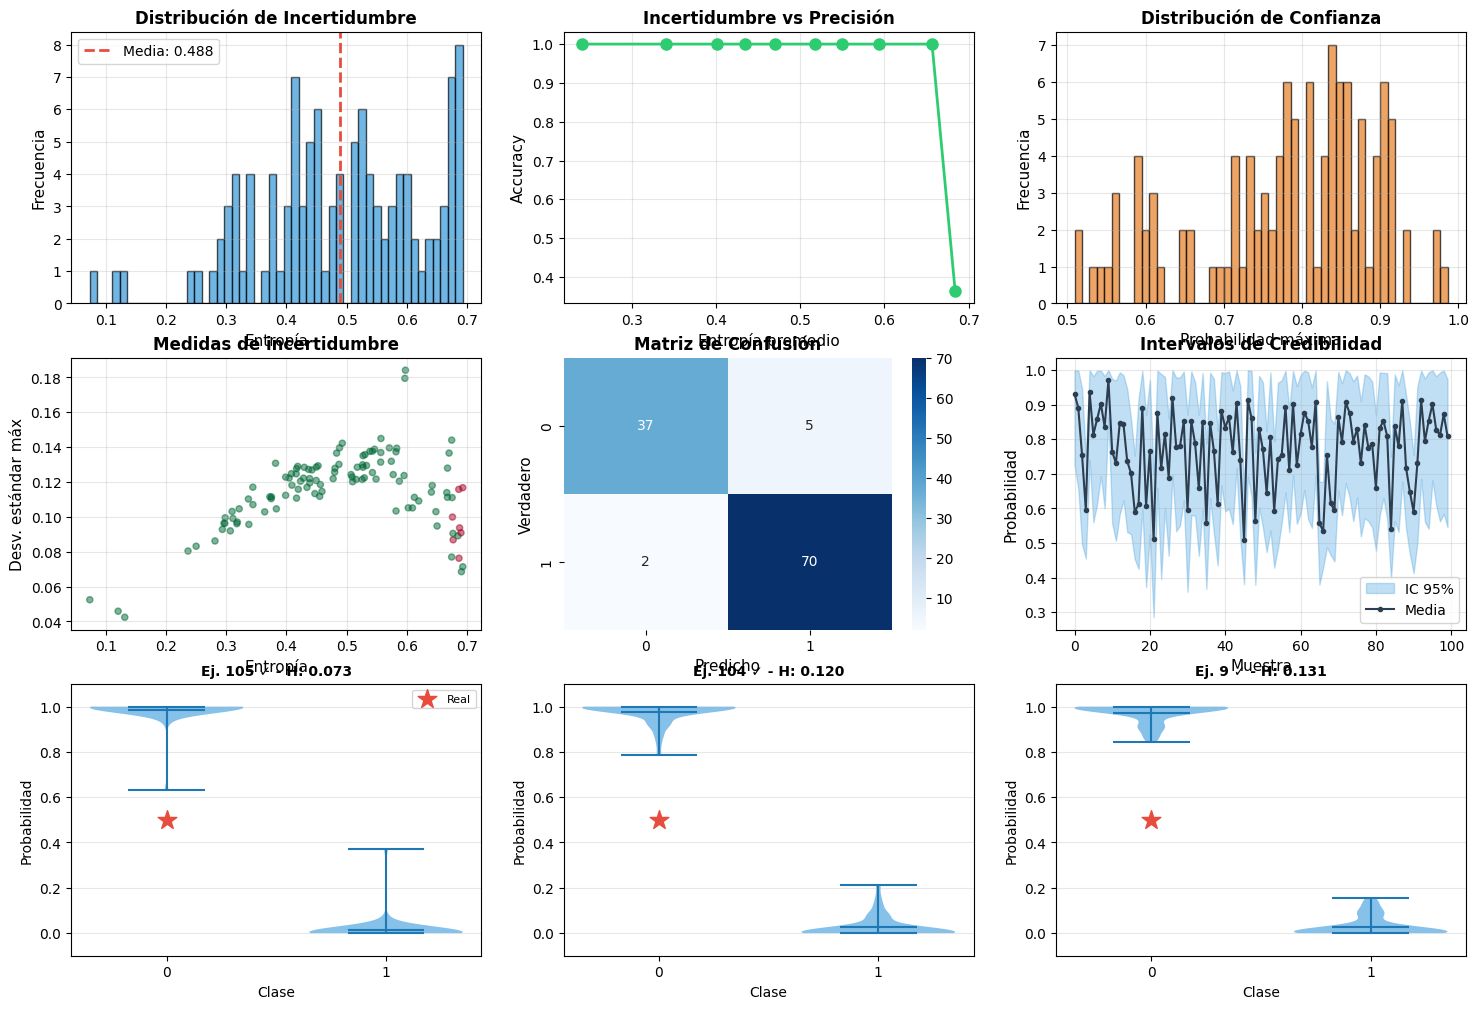

In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CLASE PRINCIPAL
# ============================================================================

class ModeloBayesianoIncertidumbre:
    """
    Red neuronal bayesiana con Dropout para cuantificar incertidumbre
    Usa ensemble de modelos para aproximar distribución posterior
    """

    def __init__(self, X, y, test_size=0.2, random_state=42):
        """Inicializa y prepara datos"""
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        # Normalización matricial
        self.scaler = StandardScaler()
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)

        self.n_classes = len(np.unique(y))
        self.modelo = None

    def crear_modelo_bayesiano(self, n_estimators=50):
        """
        Crea ensemble de MLPs como aproximación bayesiana
        CORRECCIÓN: Sin max_features para evitar error de dimensiones
        """
        base_model = MLPClassifier(
            hidden_layer_sizes=(100, 50),
            activation='relu',
            max_iter=500,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1
        )

        # Bagging solo con bootstrap de muestras (NO de features)
        self.modelo = BaggingClassifier(
            base_model,
            n_estimators=n_estimators,
            max_samples=0.8,
            bootstrap=True,
            random_state=42,
            n_jobs=-1
        )

        self.modelo.fit(self.X_train, self.y_train)

    def predecir_con_incertidumbre(self, X, n_samples=50):
        """Genera predicciones con intervalos de credibilidad"""
        # Matriz de predicciones: (n_samples, n_instances, n_classes)
        predicciones = np.array([
            estimator.predict_proba(X)
            for estimator in self.modelo.estimators_[:n_samples]
        ])

        # Estadísticas matriciales
        media_prob = predicciones.mean(axis=0)
        std_prob = predicciones.std(axis=0)
        pred_clase = media_prob.argmax(axis=1)

        # Entropía (vectorizada)
        entropia = -np.sum(media_prob * np.log(media_prob + 1e-10), axis=1)

        # Intervalos de credibilidad
        percentil_lower = np.percentile(predicciones, 2.5, axis=0)
        percentil_upper = np.percentile(predicciones, 97.5, axis=0)

        return {
            'predicciones': pred_clase,
            'probabilidades_media': media_prob,
            'probabilidades_std': std_prob,
            'entropia': entropia,
            'intervalo_lower': percentil_lower,
            'intervalo_upper': percentil_upper,
            'distribuciones_completas': predicciones
        }

    def identificar_alta_incertidumbre(self, resultados, threshold_percentil=90):
        """Identifica muestras con alta incertidumbre"""
        entropia = resultados['entropia']
        umbral = np.percentile(entropia, threshold_percentil)
        indices_inciertos = np.where(entropia >= umbral)[0]

        return {
            'indices': indices_inciertos,
            'entropias': entropia[indices_inciertos],
            'umbral': umbral
        }

    def visualizar_incertidumbre(self, resultados_test, n_ejemplos=6):
        """Visualización completa de incertidumbre"""
        fig = plt.figure(figsize=(18, 12))

        # 1. Distribución de entropía
        ax1 = plt.subplot(3, 3, 1)
        entropia = resultados_test['entropia']
        ax1.hist(entropia, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
        ax1.axvline(entropia.mean(), color='#e74c3c', linestyle='--',
                   linewidth=2, label=f'Media: {entropia.mean():.3f}')
        ax1.set_xlabel('Entropía', fontsize=11)
        ax1.set_ylabel('Frecuencia', fontsize=11)
        ax1.set_title('Distribución de Incertidumbre', fontsize=12, fontweight='bold')
        ax1.legend()
        ax1.grid(alpha=0.3)

        # 2. Accuracy vs Incertidumbre
        ax2 = plt.subplot(3, 3, 2)
        pred_correcta = (resultados_test['predicciones'] == self.y_test).astype(int)

        n_bins = 10
        bins = np.percentile(entropia, np.linspace(0, 100, n_bins + 1))
        bin_indices = np.digitize(entropia, bins) - 1

        acc_por_bin = np.array([
            pred_correcta[bin_indices == i].mean() if (bin_indices == i).sum() > 0 else np.nan
            for i in range(n_bins)
        ])
        entropia_por_bin = np.array([
            entropia[bin_indices == i].mean() if (bin_indices == i).sum() > 0 else np.nan
            for i in range(n_bins)
        ])

        mask = ~np.isnan(acc_por_bin)
        ax2.plot(entropia_por_bin[mask], acc_por_bin[mask], 'o-', color='#2ecc71',
                linewidth=2, markersize=8)
        ax2.set_xlabel('Entropía promedio', fontsize=11)
        ax2.set_ylabel('Accuracy', fontsize=11)
        ax2.set_title('Incertidumbre vs Precisión', fontsize=12, fontweight='bold')
        ax2.grid(alpha=0.3)

        # 3. Distribución de probabilidades máximas
        ax3 = plt.subplot(3, 3, 3)
        prob_max = resultados_test['probabilidades_media'].max(axis=1)
        ax3.hist(prob_max, bins=50, color='#e67e22', alpha=0.7, edgecolor='black')
        ax3.set_xlabel('Probabilidad máxima', fontsize=11)
        ax3.set_ylabel('Frecuencia', fontsize=11)
        ax3.set_title('Distribución de Confianza', fontsize=12, fontweight='bold')
        ax3.grid(alpha=0.3)

        # 4. Desviación estándar vs Entropía
        ax4 = plt.subplot(3, 3, 4)
        std_max = resultados_test['probabilidades_std'].max(axis=1)
        ax4.scatter(entropia, std_max, alpha=0.5, s=20, c=pred_correcta, cmap='RdYlGn')
        ax4.set_xlabel('Entropía', fontsize=11)
        ax4.set_ylabel('Desv. estándar máx', fontsize=11)
        ax4.set_title('Medidas de incertidumbre', fontsize=12, fontweight='bold')
        ax4.grid(alpha=0.3)

        # 5. Matriz de confusión
        from sklearn.metrics import confusion_matrix
        ax5 = plt.subplot(3, 3, 5)
        cm = confusion_matrix(self.y_test, resultados_test['predicciones'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax5)
        ax5.set_ylabel('Verdadero', fontsize=11)
        ax5.set_xlabel('Predicho', fontsize=11)
        ax5.set_title('Matriz de Confusión', fontsize=12, fontweight='bold')

        # 6. Intervalos de credibilidad
        ax6 = plt.subplot(3, 3, 6)
        pred_clase_idx = resultados_test['predicciones']
        n_muestras = min(100, len(pred_clase_idx))
        indices = np.arange(n_muestras)

        lower = resultados_test['intervalo_lower'][indices, pred_clase_idx[indices]]
        upper = resultados_test['intervalo_upper'][indices, pred_clase_idx[indices]]
        media = resultados_test['probabilidades_media'][indices, pred_clase_idx[indices]]

        ax6.fill_between(indices, lower, upper, alpha=0.3, color='#3498db', label='IC 95%')
        ax6.plot(indices, media, '-o', color='#2c3e50', markersize=3, label='Media')
        ax6.set_xlabel('Muestra', fontsize=11)
        ax6.set_ylabel('Probabilidad', fontsize=11)
        ax6.set_title('Intervalos de Credibilidad', fontsize=12, fontweight='bold')
        ax6.legend()
        ax6.grid(alpha=0.3)

        # 7-9. Ejemplos individuales
        indices_baja_inc = np.argsort(entropia)[:n_ejemplos//2]
        indices_alta_inc = np.argsort(entropia)[-n_ejemplos//2:]
        indices_ejemplos = np.concatenate([indices_baja_inc, indices_alta_inc])

        for idx, ejemplo_idx in enumerate(indices_ejemplos):
            ax = plt.subplot(3, 3, 7 + idx)

            dist = resultados_test['distribuciones_completas'][:, ejemplo_idx, :]
            positions = np.arange(self.n_classes)
            parts = ax.violinplot([dist[:, c] for c in range(self.n_classes)],
                                  positions=positions, widths=0.7,
                                  showmeans=True, showextrema=True)

            for pc in parts['bodies']:
                pc.set_facecolor('#3498db')
                pc.set_alpha(0.6)

            clase_verdadera = self.y_test[ejemplo_idx]
            ax.scatter(clase_verdadera, 0.5, color='#e74c3c', s=200,
                      marker='*', zorder=5, label='Real')

            correcto = "✓" if resultados_test['predicciones'][ejemplo_idx] == clase_verdadera else "✗"
            ax.set_xlabel('Clase', fontsize=10)
            ax.set_ylabel('Probabilidad', fontsize=10)
            ax.set_title(f'Ej. {ejemplo_idx} {correcto} - H: {entropia[ejemplo_idx]:.3f}',
                        fontsize=10, fontweight='bold')
            ax.set_xticks(positions)
            ax.set_ylim(-0.1, 1.1)
            ax.grid(alpha=0.3, axis='y')
            if idx == 0:
                ax.legend(loc='upper right', fontsize=8)

        plt.tight_layout()
        return fig

    def generar_reporte_incertidumbre(self, resultados_test):
        """Reporte de análisis"""
        muestras_inciertas = self.identificar_alta_incertidumbre(resultados_test)
        accuracy = accuracy_score(self.y_test, resultados_test['predicciones'])

        entropia = resultados_test['entropia']
        umbral_medio = np.median(entropia)

        bajo_inc = entropia < umbral_medio
        alto_inc = entropia >= umbral_medio

        acc_bajo_inc = accuracy_score(self.y_test[bajo_inc], resultados_test['predicciones'][bajo_inc])
        acc_alto_inc = accuracy_score(self.y_test[alto_inc], resultados_test['predicciones'][alto_inc])

        lineas = ["=" * 70]
        lineas.append("REPORTE: CUANTIFICACIÓN DE INCERTIDUMBRE")
        lineas.append("=" * 70)
        lineas.append(f"\nAccuracy: {accuracy:.4f}")
        lineas.append(f"Entropía media: {entropia.mean():.4f} ± {entropia.std():.4f}")
        lineas.append(f"\nMuestras alta incertidumbre (top 10%): {len(muestras_inciertas['indices'])}")
        lineas.append(f"Umbral: {muestras_inciertas['umbral']:.4f}")
        lineas.append(f"\nAccuracy BAJA incertidumbre: {acc_bajo_inc:.4f}")
        lineas.append(f"Accuracy ALTA incertidumbre: {acc_alto_inc:.4f}")
        lineas.append(f"Diferencia: {(acc_bajo_inc - acc_alto_inc)*100:.2f} pp")
        lineas.append("\n" + "=" * 70)

        return "\n".join(lineas)

# ============================================================================
# FUNCIÓN PRINCIPAL
# ============================================================================

def ejecutar_ejercicio2():
    """Ejecuta el ejercicio completo"""
    print("="*70)
    print("EJERCICIO 2: CUANTIFICACIÓN DE INCERTIDUMBRE EN PREDICCIONES")
    print("="*70)

    # Cargar datos
    print("\n[1/4] Cargando dataset Breast Cancer...")
    datos = load_breast_cancer()
    X, y = datos.data, datos.target
    print(f"      Dimensiones: {X.shape}, Clases: {np.unique(y)}")

    # Crear modelo
    print("\n[2/4] Entrenando ensemble de redes neuronales (50 modelos)...")
    modelo = ModeloBayesianoIncertidumbre(X, y)
    modelo.crear_modelo_bayesiano(n_estimators=50)

    # Predicciones
    print("\n[3/4] Generando predicciones con intervalos de credibilidad...")
    resultados_test = modelo.predecir_con_incertidumbre(modelo.X_test, n_samples=50)

    # Visualización
    print("\n[4/4] Generando visualizaciones...")
    fig = modelo.visualizar_incertidumbre(resultados_test)
    plt.savefig('ejercicio2_incertidumbre.png', dpi=150, bbox_inches='tight')
    print("      ✓ Gráfico guardado: ejercicio2_incertidumbre.png")
    plt.show()

    # Reporte
    reporte = modelo.generar_reporte_incertidumbre(resultados_test)
    print("\n" + reporte)

    return modelo, resultados_test

# ============================================================================
# EJECUCIÓN
# ============================================================================

if __name__ == "__main__":
    modelo, resultados = ejecutar_ejercicio2()


EJERCICIO 3: CLASIFICACIÓN NLP BAYESIANA

[1/5] Inicializando clasificador NLP...

[2/5] Cargando dataset 20 Newsgroups...
      Entrenamiento: 2034 documentos
      Prueba: 1353 documentos

[3/5] Entrenando Naive Bayes...

[4/5] Generando predicciones...

[5/5] Generando visualizaciones...
      ✓ Gráfico guardado: ejercicio3_nlp_bayesiano.png


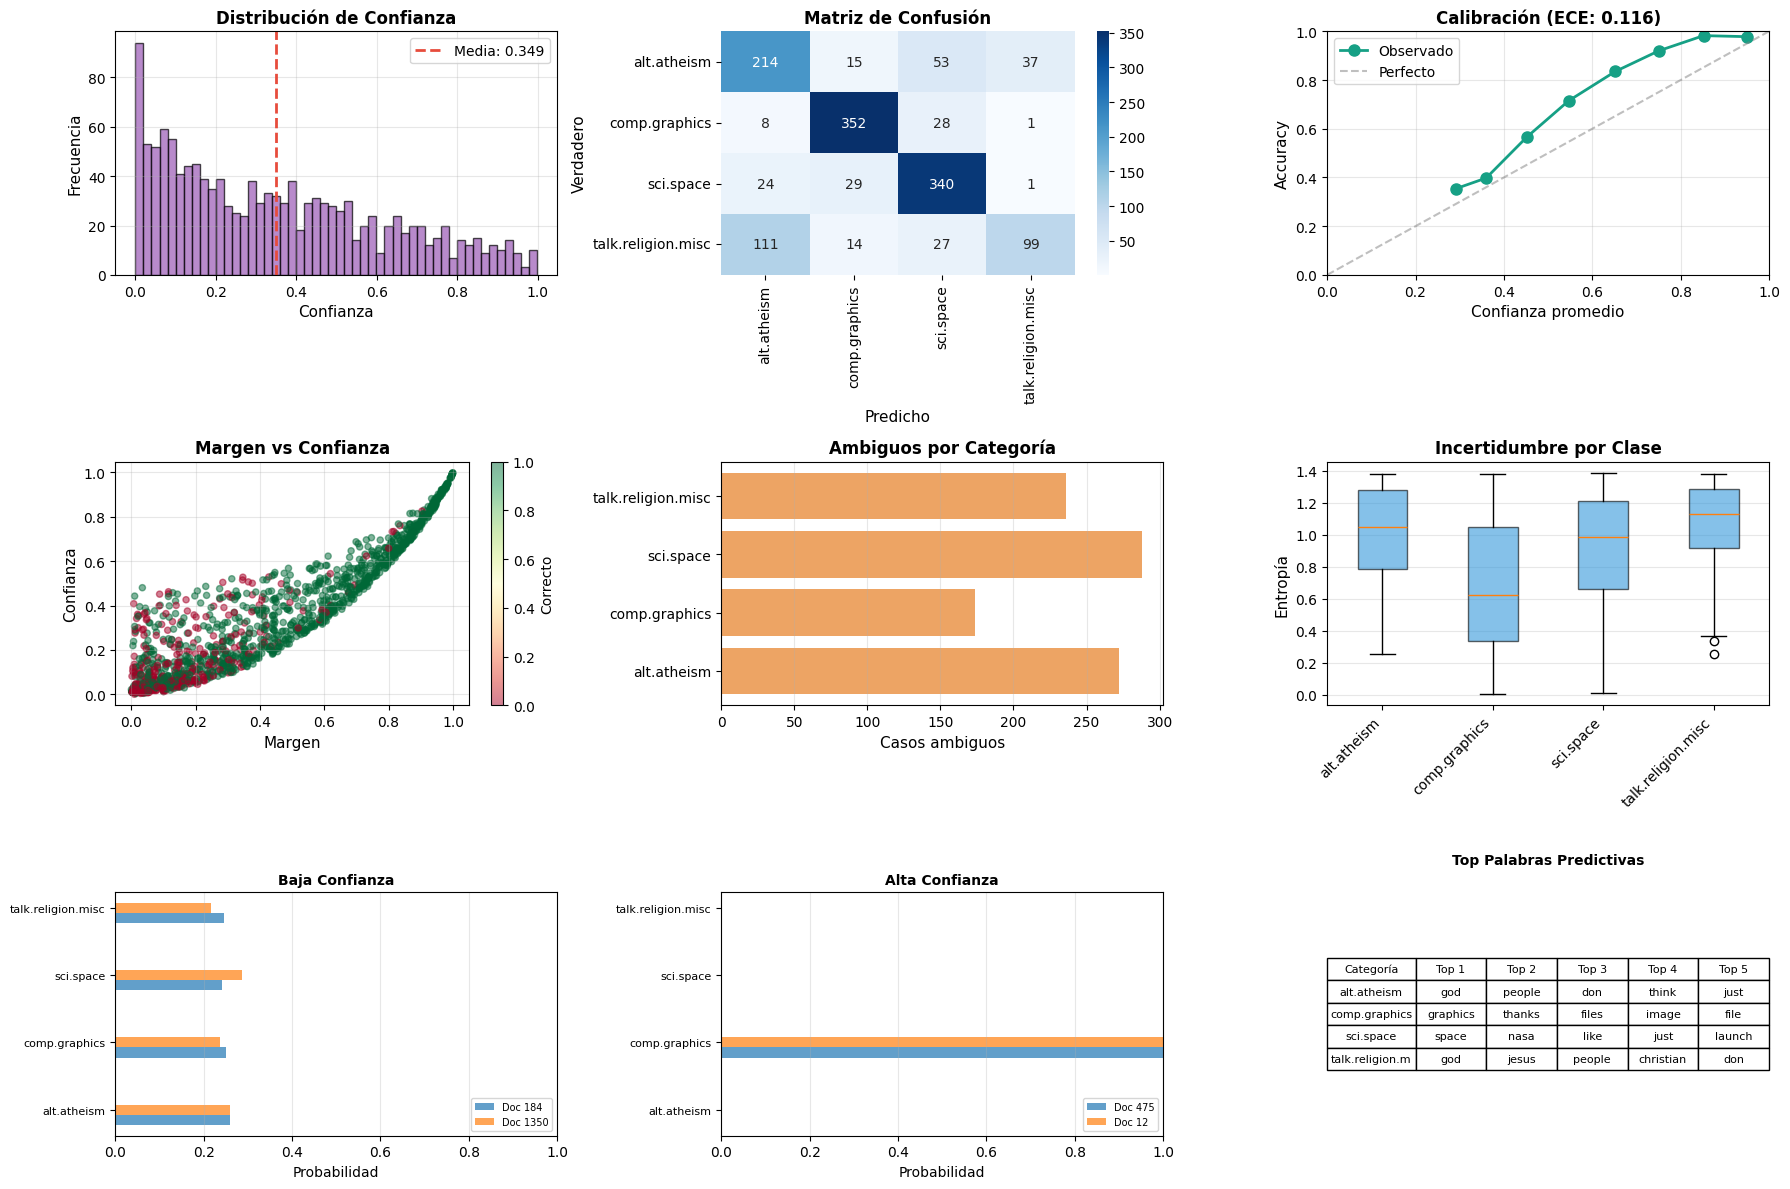


REPORTE: CLASIFICACIÓN NLP BAYESIANA

Dataset: 20 Newsgroups
Categorías: alt.atheism, comp.graphics, sci.space, talk.religion.misc

Accuracy: 0.7428
Log Loss: 0.6780
ECE: 0.1162

Confianza media: 0.3490
Casos ambiguos: 717 (53.0%)

Accuracy SEGURAS: 0.9634
Accuracy AMBIGUAS: 0.6557
Diferencia: 30.78 pp

                    precision    recall  f1-score   support

       alt.atheism     0.5994    0.6708    0.6331       319
     comp.graphics     0.8585    0.9049    0.8811       389
         sci.space     0.7589    0.8629    0.8076       394
talk.religion.misc     0.7174    0.3944    0.5090       251

          accuracy                         0.7428      1353
         macro avg     0.7336    0.7083    0.7077      1353
      weighted avg     0.7423    0.7428    0.7322      1353



In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CLASE PRINCIPAL
# ============================================================================

class ClasificadorNLPBayesiano:
    """Clasificación de textos con cuantificación de incertidumbre"""

    def __init__(self, categorias=None, max_features=1000):
        """Inicializa clasificador"""
        self.categorias = categorias
        self.max_features = max_features
        self.vectorizer = TfidfVectorizer(
            max_features=max_features,
            stop_words='english',
            ngram_range=(1, 2)
        )
        self.modelo = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.nombres_categorias = None

    def cargar_datos(self):
        """Carga dataset de 20newsgroups"""
        if self.categorias is None:
            self.categorias = [
                'alt.atheism',
                'talk.religion.misc',
                'comp.graphics',
                'sci.space'
            ]

        datos_train = fetch_20newsgroups(
            subset='train',
            categories=self.categorias,
            shuffle=True,
            random_state=42,
            remove=('headers', 'footers', 'quotes')
        )

        datos_test = fetch_20newsgroups(
            subset='test',
            categories=self.categorias,
            shuffle=True,
            random_state=42,
            remove=('headers', 'footers', 'quotes')
        )

        self.X_train = self.vectorizer.fit_transform(datos_train.data)
        self.X_test = self.vectorizer.transform(datos_test.data)
        self.y_train = datos_train.target
        self.y_test = datos_test.target

        self.nombres_categorias = datos_train.target_names
        self.textos_test = datos_test.data

        return self.X_train, self.y_train, self.X_test, self.y_test

    def entrenar_naive_bayes(self, alpha=1.0):
        """Entrena Naive Bayes Multinomial"""
        self.modelo = MultinomialNB(alpha=alpha, fit_prior=True)
        self.modelo.fit(self.X_train, self.y_train)

    def predecir_con_confianza(self, X):
        """Predicciones con probabilidades calibradas"""
        pred = self.modelo.predict(X)
        proba = self.modelo.predict_proba(X)

        # Entropía normalizada (vectorizado)
        entropia = -np.sum(proba * np.log(proba + 1e-10), axis=1)
        entropia_max = np.log(len(self.nombres_categorias))
        entropia_norm = entropia / entropia_max

        # Confianza
        confianza = 1 - entropia_norm

        # Margen
        proba_sorted = -np.sort(-proba, axis=1)
        margen = proba_sorted[:, 0] - proba_sorted[:, 1]

        return {
            'predicciones': pred,
            'probabilidades': proba,
            'confianza': confianza,
            'entropia': entropia,
            'entropia_normalizada': entropia_norm,
            'margen': margen
        }

    def identificar_casos_ambiguos(self, resultados, threshold=0.3):
        """Identifica textos con clasificación ambigua"""
        confianza = resultados['confianza']
        margen = resultados['margen']

        indices_ambiguos = np.where((confianza < threshold) | (margen < 0.2))[0]

        return {
            'indices': indices_ambiguos,
            'confianzas': confianza[indices_ambiguos],
            'margenes': margen[indices_ambiguos],
            'probabilidades': resultados['probabilidades'][indices_ambiguos]
        }

    def analizar_calibracion(self, resultados):
        """Analiza calibración de probabilidades"""
        pred_correcta = (resultados['predicciones'] == self.y_test)
        prob_max = resultados['probabilidades'].max(axis=1)

        n_bins = 10
        bins = np.linspace(0, 1, n_bins + 1)
        bin_indices = np.digitize(prob_max, bins) - 1

        acc_por_bin = np.array([
            pred_correcta[bin_indices == i].mean()
            if (bin_indices == i).sum() > 0 else np.nan
            for i in range(n_bins)
        ])

        conf_por_bin = np.array([
            prob_max[bin_indices == i].mean()
            if (bin_indices == i).sum() > 0 else np.nan
            for i in range(n_bins)
        ])

        cuenta_por_bin = np.array([(bin_indices == i).sum() for i in range(n_bins)])

        # ECE
        mask = ~np.isnan(acc_por_bin)
        ece = np.sum(
            np.abs(acc_por_bin[mask] - conf_por_bin[mask]) * cuenta_por_bin[mask]
        ) / pred_correcta.shape[0]

        return {
            'accuracy_por_bin': acc_por_bin,
            'confianza_por_bin': conf_por_bin,
            'cuenta_por_bin': cuenta_por_bin,
            'ece': ece
        }

    def visualizar_resultados_nlp(self, resultados_test, n_ejemplos=4):
        """Visualización completa"""
        fig = plt.figure(figsize=(18, 12))

        # 1. Distribución de confianza
        ax1 = plt.subplot(3, 3, 1)
        confianza = resultados_test['confianza']
        ax1.hist(confianza, bins=50, color='#9b59b6', alpha=0.7, edgecolor='black')
        ax1.axvline(confianza.mean(), color='#e74c3c', linestyle='--',
                   linewidth=2, label=f'Media: {confianza.mean():.3f}')
        ax1.set_xlabel('Confianza', fontsize=11)
        ax1.set_ylabel('Frecuencia', fontsize=11)
        ax1.set_title('Distribución de Confianza', fontsize=12, fontweight='bold')
        ax1.legend()
        ax1.grid(alpha=0.3)

        # 2. Matriz de confusión
        ax2 = plt.subplot(3, 3, 2)
        cm = confusion_matrix(self.y_test, resultados_test['predicciones'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.nombres_categorias,
                   yticklabels=self.nombres_categorias, ax=ax2)
        ax2.set_ylabel('Verdadero', fontsize=11)
        ax2.set_xlabel('Predicho', fontsize=11)
        ax2.set_title('Matriz de Confusión', fontsize=12, fontweight='bold')

        # 3. Curva de calibración
        ax3 = plt.subplot(3, 3, 3)
        calibracion = self.analizar_calibracion(resultados_test)
        mask = ~np.isnan(calibracion['accuracy_por_bin'])

        ax3.plot(calibracion['confianza_por_bin'][mask],
                calibracion['accuracy_por_bin'][mask],
                'o-', color='#16a085', linewidth=2, markersize=8, label='Observado')
        ax3.plot([0, 1], [0, 1], '--', color='gray', alpha=0.5, label='Perfecto')
        ax3.set_xlabel('Confianza promedio', fontsize=11)
        ax3.set_ylabel('Accuracy', fontsize=11)
        ax3.set_title(f'Calibración (ECE: {calibracion["ece"]:.3f})', fontsize=12, fontweight='bold')
        ax3.legend()
        ax3.grid(alpha=0.3)
        ax3.set_xlim(0, 1)
        ax3.set_ylim(0, 1)

        # 4. Confianza vs Margen
        ax4 = plt.subplot(3, 3, 4)
        pred_correcta = (resultados_test['predicciones'] == self.y_test).astype(int)
        scatter = ax4.scatter(resultados_test['margen'], confianza,
                            c=pred_correcta, cmap='RdYlGn', alpha=0.5, s=20)
        ax4.set_xlabel('Margen', fontsize=11)
        ax4.set_ylabel('Confianza', fontsize=11)
        ax4.set_title('Margen vs Confianza', fontsize=12, fontweight='bold')
        plt.colorbar(scatter, ax=ax4, label='Correcto')
        ax4.grid(alpha=0.3)

        # 5. Casos ambiguos
        ax5 = plt.subplot(3, 3, 5)
        casos_ambiguos = self.identificar_casos_ambiguos(resultados_test, threshold=0.5)

        categorias_ambiguas = self.y_test[casos_ambiguos['indices']]
        cuenta_ambiguos = np.array([
            np.sum(categorias_ambiguas == i)
            for i in range(len(self.nombres_categorias))
        ])

        bars = ax5.barh(self.nombres_categorias, cuenta_ambiguos, color='#e67e22', alpha=0.7)
        ax5.set_xlabel('Casos ambiguos', fontsize=11)
        ax5.set_title('Ambiguos por Categoría', fontsize=12, fontweight='bold')
        ax5.grid(axis='x', alpha=0.3)

        # 6. Entropía por clase
        ax6 = plt.subplot(3, 3, 6)
        entropia_por_clase = [
            resultados_test['entropia'][self.y_test == i]
            for i in range(len(self.nombres_categorias))
        ]

        bp = ax6.boxplot(entropia_por_clase, labels=self.nombres_categorias, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor('#3498db')
            patch.set_alpha(0.6)
        ax6.set_ylabel('Entropía', fontsize=11)
        ax6.set_title('Incertidumbre por Clase', fontsize=12, fontweight='bold')
        ax6.grid(alpha=0.3, axis='y')
        plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45, ha='right')

        # 7-8. Ejemplos
        indices_baja_conf = np.argsort(confianza)[:n_ejemplos//2]
        indices_alta_conf = np.argsort(confianza)[-n_ejemplos//2:]

        for idx, (titulo, indices_sel) in enumerate([
            ('Baja Confianza', indices_baja_conf),
            ('Alta Confianza', indices_alta_conf)
        ]):
            ax = plt.subplot(3, 3, 7 + idx)

            for j, i in enumerate(indices_sel):
                probs = resultados_test['probabilidades'][i]
                y_pos = np.arange(len(self.nombres_categorias)) + j * 0.15
                ax.barh(y_pos, probs, height=0.15, alpha=0.7, label=f'Doc {i}')

            ax.set_xlabel('Probabilidad', fontsize=10)
            ax.set_yticks(np.arange(len(self.nombres_categorias)) + 0.15)
            ax.set_yticklabels(self.nombres_categorias, fontsize=8)
            ax.set_title(f'{titulo}', fontsize=10, fontweight='bold')
            ax.legend(fontsize=7, loc='lower right')
            ax.grid(alpha=0.3, axis='x')
            ax.set_xlim(0, 1)

        # 9. Top palabras
        ax9 = plt.subplot(3, 3, 9)
        log_probs = self.modelo.feature_log_prob_
        feature_names = np.array(self.vectorizer.get_feature_names_out())

        n_top = 5
        top_indices = np.argsort(-log_probs, axis=1)[:, :n_top]

        tabla_data = []
        for i, cat in enumerate(self.nombres_categorias):
            top_words = feature_names[top_indices[i]]
            tabla_data.append([cat[:15]] + list(top_words))

        ax9.axis('off')
        tabla = ax9.table(cellText=tabla_data,
                         colLabels=['Categoría'] + [f'Top {i+1}' for i in range(n_top)],
                         cellLoc='center', loc='center',
                         colWidths=[0.2] + [0.16]*n_top)
        tabla.auto_set_font_size(False)
        tabla.set_fontsize(8)
        tabla.scale(1, 1.5)
        ax9.set_title('Top Palabras Predictivas', fontsize=10, fontweight='bold', pad=20)

        plt.tight_layout()
        return fig

    def generar_reporte_nlp(self, resultados_test):
        """Reporte completo"""
        accuracy = accuracy_score(self.y_test, resultados_test['predicciones'])
        casos_ambiguos = self.identificar_casos_ambiguos(resultados_test)
        calibracion = self.analizar_calibracion(resultados_test)

        lineas = ["=" * 70]
        lineas.append("REPORTE: CLASIFICACIÓN NLP BAYESIANA")
        lineas.append("=" * 70)
        lineas.append(f"\nDataset: 20 Newsgroups")
        lineas.append(f"Categorías: {', '.join(self.nombres_categorias)}")
        lineas.append(f"\nAccuracy: {accuracy:.4f}")
        lineas.append(f"Log Loss: {log_loss(self.y_test, resultados_test['probabilidades']):.4f}")
        lineas.append(f"ECE: {calibracion['ece']:.4f}")
        lineas.append(f"\nConfianza media: {resultados_test['confianza'].mean():.4f}")
        lineas.append(f"Casos ambiguos: {len(casos_ambiguos['indices'])} ({len(casos_ambiguos['indices'])/len(self.y_test)*100:.1f}%)")

        # Accuracy seguras vs ambiguas
        seguros = resultados_test['confianza'] >= 0.5
        ambiguos_mask = resultados_test['confianza'] < 0.5

        acc_seguros = accuracy_score(self.y_test[seguros], resultados_test['predicciones'][seguros]) if seguros.sum() > 0 else 0
        acc_ambiguos = accuracy_score(self.y_test[ambiguos_mask], resultados_test['predicciones'][ambiguos_mask]) if ambiguos_mask.sum() > 0 else 0

        lineas.append(f"\nAccuracy SEGURAS: {acc_seguros:.4f}")
        lineas.append(f"Accuracy AMBIGUAS: {acc_ambiguos:.4f}")
        lineas.append(f"Diferencia: {(acc_seguros - acc_ambiguos)*100:.2f} pp")
        lineas.append("\n" + classification_report(self.y_test, resultados_test['predicciones'],
                                                    target_names=self.nombres_categorias, digits=4))
        lineas.append("=" * 70)

        return "\n".join(lineas)

# ============================================================================
# FUNCIÓN PRINCIPAL
# ============================================================================

def ejecutar_ejercicio3():
    """Ejecuta el ejercicio completo"""
    print("="*70)
    print("EJERCICIO 3: CLASIFICACIÓN NLP BAYESIANA")
    print("="*70)

    # Clasificador
    print("\n[1/5] Inicializando clasificador NLP...")
    nlp = ClasificadorNLPBayesiano(max_features=2000)

    # Cargar datos
    print("\n[2/5] Cargando dataset 20 Newsgroups...")
    nlp.cargar_datos()
    print(f"      Entrenamiento: {nlp.X_train.shape[0]} documentos")
    print(f"      Prueba: {nlp.X_test.shape[0]} documentos")

    # Entrenar
    print("\n[3/5] Entrenando Naive Bayes...")
    nlp.entrenar_naive_bayes(alpha=1.0)

    # Predicciones
    print("\n[4/5] Generando predicciones...")
    resultados_nlp = nlp.predecir_con_confianza(nlp.X_test)

    # Visualización
    print("\n[5/5] Generando visualizaciones...")
    fig = nlp.visualizar_resultados_nlp(resultados_nlp)
    plt.savefig('ejercicio3_nlp_bayesiano.png', dpi=150, bbox_inches='tight')
    print("      ✓ Gráfico guardado: ejercicio3_nlp_bayesiano.png")
    plt.show()

    # Reporte
    reporte = nlp.generar_reporte_nlp(resultados_nlp)
    print("\n" + reporte)

    return nlp, resultados_nlp

# ============================================================================
# EJECUCIÓN
# ============================================================================

if __name__ == "__main__":
    clasificador, resultados = ejecutar_ejercicio3()
